In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.style.use('seaborn')

from scipy.stats import t as t_Student

In [2]:
def df_simulacion(T=101):
    e = np.random.randn(T)
    y = e.cumsum()
    dy = y[1:]-y[:-1]
    X = sm.add_constant(y[:-1])
    Z = np.c_[X,np.arange(T-1)]
    
    res0 = sm.OLS(dy, y[:-1], hasconst=False).fit()
    res1 = sm.OLS(dy, X, hasconst=True).fit()
    res2 = sm.OLS(dy, Z, hasconst=True).fit()
    return res0.tvalues[0], res1.tvalues[1], res2.tvalues[1]

In [3]:
N = 1000 #00  usar cien mil en la versión final

In [4]:
%%time
dfvalues = pd.DataFrame([df_simulacion() for _ in range(N)], columns=['nc','c','ct'])

Wall time: 1.05 s


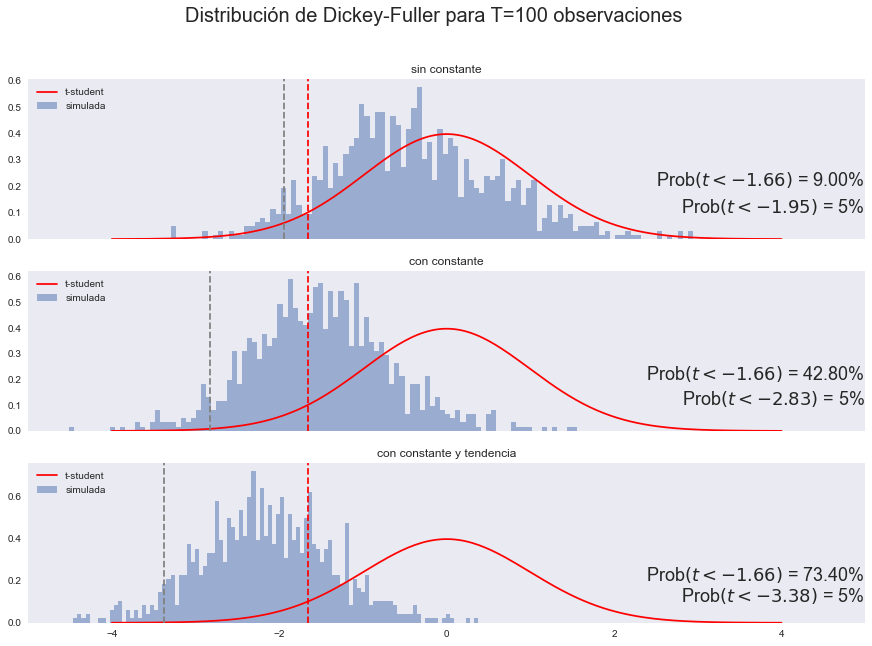

In [5]:
def plot_df(ax, data, titulo,df):
    maxtval = 5.0
    t5crit = t_Student.isf(0.05, df)

    ff, edges = np.histogram(data, bins=100, density=True)
    center = (edges[1:] + edges[:-1])/2
    w = center[1] - center[0]

    ax.bar(center, ff, width=w, alpha=0.5)
    xvals = np.linspace(-4,4, 200)
    ax.plot(xvals, t_Student.pdf(xvals, df=99), '-r')
    ax.set(xlim=[-maxtval, maxtval], title=titulo)
    ax.legend(['t-student', 'simulada'], loc='upper left')

    # valores críticos
    df5 = data.quantile(0.05)
    ax.axvline(-t5crit, ls="--", color='red')
    ax.axvline(df5, ls="--", color='gray')

    # error tipo I
    err1 = (data < -t5crit).mean()*100
    ax.annotate(f'Prob$\\left(t < -1.66\\right)$ = {err1:.2f}%', (5,0.2), size=18, ha='right')
    ax.annotate(f'Prob$\\left(t < {df5:.2f}\\right)$ = 5%', (5,0.1), size=18, ha='right')
    ax.grid(False)


fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=[15,10], sharex=True)

plot_df(ax0, dfvalues['nc'],'sin constante',99)
plot_df(ax1, dfvalues['c'],'con constante',98)
plot_df(ax2, dfvalues['ct'],'con constante y tendencia',97)

fig.suptitle('Distribución de Dickey-Fuller para T=100 observaciones', size=20);

In [6]:
df5crit = dfvalues.quantile(0.05)

In [7]:
def df_simulacion_power(rho=0.95, T=101):
    e = np.random.randn(T)
    y = np.zeros(T)
    for t in range(1,T):
        y[t] = rho*y[t-1] + e[t]
    
    dy = y[1:] -y[:-1]
    X = sm.add_constant(y[:-1])
    Z = np.c_[X,np.arange(T-1)]
    
    res0 = sm.OLS(dy, y[:-1], hasconst=False).fit()
    res1 = sm.OLS(dy, X, hasconst=True).fit()
    res2 = sm.OLS(dy, Z, hasconst=True).fit()
    return res0.tvalues[0], res1.tvalues[1], res2.tvalues[1]

In [8]:
%%time
dfvaluespower = pd.DataFrame([df_simulacion_power() for _ in range(N)], columns=['nc','c','ct'])

Wall time: 1.43 s


In [9]:
def plot_df2(ax, data, spec, titulo,df):
    #maxtval = 5.0
    #t5crit = t.isf(0.05, df)

    ff, edges = np.histogram(data, bins=100, density=True)
    center = (edges[1:] + edges[:-1])/2
    w = center[1] - center[0]

    ax.bar(center, ff, width=w, alpha=0.5)
    #xvals = np.linspace(-4,4, 200)
    #ax.plot(xvals, t.pdf(xvals, df=99), '-r')
    ax.set(xlim=[-5, 2], title=titulo)
    

    # valores críticos
    df5 = df5crit[spec]
    ax.axvline(df5, ls="--", color='gray')
    ax.legend(['Valor crítico Dickey-Fuller', 'estadístico $t$ simulado'], loc='upper left')
    # error tipo II
    
    err2 = (data > df5).mean()*100
    ax.annotate(f'Prob$\\left(t > {df5:.2f}\\right)$ = {err2:.2f}%', (1.5,0.5), size=18, ha='right')
    ax.grid(False)

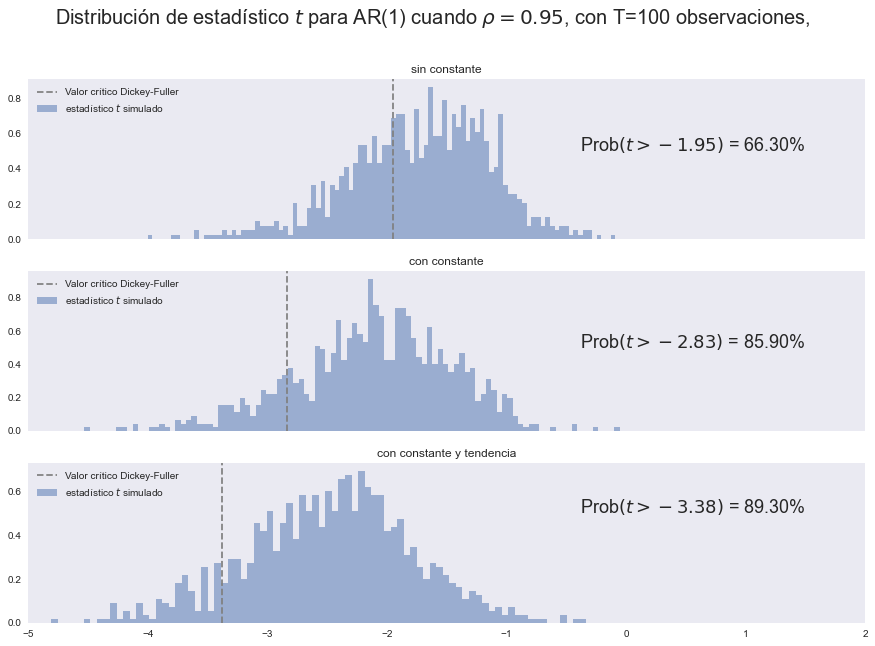

In [10]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=[15,10], sharex=True)

plot_df2(ax0, dfvaluespower['nc'],'nc','sin constante',99)
plot_df2(ax1, dfvaluespower['c'],'c','con constante',98)
plot_df2(ax2, dfvaluespower['ct'],'ct','con constante y tendencia',97)

fig.suptitle('Distribución de estadístico $t$ para AR(1) cuando $\\rho=0.95$, con T=100 observaciones, ', size=20);